# Premier League 2023/24 predictions

## Importing libraries

In [415]:
import pandas as pd

# Load the dataset from the excel file
#file_path = 'all-euro-data-2023-2024.xlsx'
#df = pd.read_excel(file_path, sheet_name='E0')

# updating the dataset with the recent games played
df = pd.read_csv('E0.csv')

# Display the first few rows of the dataset
df.tail()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
173,E0,23/12/2023,15:00,Luton,Newcastle,1,0,H,1,0,...,2.02,1.00,1.82,2.11,1.76,2.18,1.88,2.18,1.80,2.08
174,E0,23/12/2023,15:00,Nott'm Forest,Bournemouth,2,3,A,0,0,...,1.93,0.00,2.13,1.81,2.13,1.82,2.17,1.83,2.08,1.80
175,E0,23/12/2023,15:00,Tottenham,Everton,2,1,H,2,0,...,2.49,-0.75,1.89,2.04,1.89,2.03,1.95,2.12,1.86,2.00
176,E0,23/12/2023,17:30,Liverpool,Arsenal,1,1,D,1,1,...,2.30,0.00,1.86,2.07,1.86,2.07,1.89,2.17,1.82,2.07
177,E0,24/12/2023,13:00,Wolves,Chelsea,2,1,H,0,0,...,2.09,0.25,1.98,1.95,2.01,1.92,2.06,1.95,1.96,1.89


In [416]:
print(df.columns)

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH',
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object', length=106)


## Data cleaning

In [417]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [418]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y')

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Columns: 106 entries, Div to AvgCAHA
dtypes: datetime64[ns](1), float64(82), int64(16), object(7)
memory usage: 147.5+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,2.02,2.00,1.92,1.95
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

## Encode team names

In [419]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])


## Recent form

In [420]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')



## Team Points

In [421]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)


## Head-to-Head Statistics

In [422]:
# Head-to-Head Statistics
# For simplicity, we can count the number of wins, draws, and losses in matches between the same teams
# Note: This implementation is simplified for demonstration purposes
def head_to_head_stats(home_team, away_team, df_cleaned):
    head_to_head_matches = df_cleaned[(df_cleaned['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)]
    wins = len(head_to_head_matches[head_to_head_matches['FTR'] == 'H'])
    draws = len(head_to_head_matches[head_to_head_matches['FTR'] == 'D'])
    losses = len(head_to_head_matches[head_to_head_matches['FTR'] == 'A'])
    return wins, draws, losses

# Apply the head-to-head stats function
df_cleaned['HeadToHeadWins'], df_cleaned['HeadToHeadDraws'], df_cleaned['HeadToHeadLosses'] = zip(*df_cleaned.apply(lambda x: head_to_head_stats(x['HomeTeam'], x['AwayTeam'], df_cleaned), axis=1))

In [423]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)
# 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage']].head())

      HomeTeam  HomeTeamWinPercentage       AwayTeam  AwayTeamWinPercentage
0      Burnley               0.111111       Man City               0.555556
1      Arsenal               0.777778  Nott'm Forest               0.111111
2  Bournemouth               0.250000       West Ham               0.444444
3     Brighton               0.444444          Luton               0.125000
4      Everton               0.333333         Fulham               0.111111


In [424]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayTeamRecentForm,HomeTeamAvgGoals,AwayTeamAvgGoals,HomeTeamPoints,AwayTeamPoints,HeadToHeadWins,HeadToHeadDraws,HeadToHeadLosses,HomeTeamWinPercentage,AwayTeamWinPercentage
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,6,1.111111,2.000000,11,34,0,0,1,0.111111,0.555556
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,1,2.444444,0.777778,40,14,1,0,0,0.777778,0.111111
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,10,1.000000,1.555556,22,30,0,1,0,0.250000,0.444444
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,6,2.000000,0.875000,27,12,1,0,0,0.444444,0.125000
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,6,1.111111,1.000000,26,21,0,0,1,0.333333,0.111111


In [425]:
# get the current position and calculate points for chelsea and the rest of the teams
def calculate_points_goals(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']

    if row['FTR'] == 'H':
        home_points = 3
    elif row['FTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['FTHG'], row['FTAG']])

# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()
team_stats['GoalDiff'] = df_cleaned.groupby('HomeTeam')['HomeGoalDiff'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoalDiff'].sum()
team_stats['GoalsScored'] = df_cleaned.groupby('HomeTeam')['HomeGoals'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoals'].sum()

# Deducting 10 points from Everton for misconduct
team_stats.loc['Everton', 'Points'] = team_stats.loc['Everton', 'Points'] - 10

# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])

# Finding Chelsea's position
chelsea_position_updated = sorted_teams.index.get_loc('Chelsea') + 1
print('Chelsea is currently in position:', chelsea_position_updated)
sorted_teams.head(20), chelsea_position_updated


Chelsea is currently in position: 10


(                  Points  GoalDiff  GoalsScored
 Arsenal               40        20           36
 Liverpool             39        21           37
 Aston Villa           39        16           38
 Tottenham             36        13           37
 Man City              34        20           40
 West Ham              30         1           31
 Newcastle             29        14           36
 Man United            28        -5           18
 Brighton              27         3           34
 Chelsea               22         1           29
 Wolves                22        -7           23
 Bournemouth           22        -8           24
 Fulham                21        -5           26
 Brentford             19         0           24
 Crystal Palace        18        -8           18
 Everton               16         1           23
 Nott'm Forest         14       -14           19
 Luton                 12       -14           18
 Burnley               11       -18           18
 Sheffield United   

## Data Preprocessing
### steps:
* Scaling Numeric Features: We'll scale features like recent form, average goals, and points using StandardScaler.
* Handling Categorical Variables: We have already encoded team names. We'll ensure other categorical features, if any, are properly encoded.
* Splitting the Data: We'll split the data into training and test sets. We'll use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [ ]:
# another features option to add
# 1. Average possession
# 2. Number of shots on target
# 3. Defensive strength
# 4. Number of goals conceded
# 5. Number of goals scored
# 6. Number of shots on target
# 7. Number of shots off target
# 8. Number of corners
# 9. Number of fouls
# 10. Number of yellow cards
# 11. Number of red cards
# 12. Number of offsides
# HS = Home Team Shots
# AS = Away Team Shots
# HST = Home Team Shots on Target
# AST = Away Team Shots on Target
# HHW = Home Team Hit Woodwork
# AHW = Away Team Hit Woodwork
# HC = Home Team Corners
# AC = Away Team Corners

In [426]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage']
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

In [427]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1)
    
}


## Creating the Objective Function so that we can use it in the hyperparameter optimization

In [428]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(3)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [429]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [01:13<00:00,  3.69s/trial, best loss: -0.6354166666666666]


In [430]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.62      0.83      0.71        12
           D       0.25      0.20      0.22         5
           H       0.88      0.74      0.80        19

    accuracy                           0.69        36
   macro avg       0.58      0.59      0.58        36
weighted avg       0.70      0.69      0.69        36


In [431]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.609375


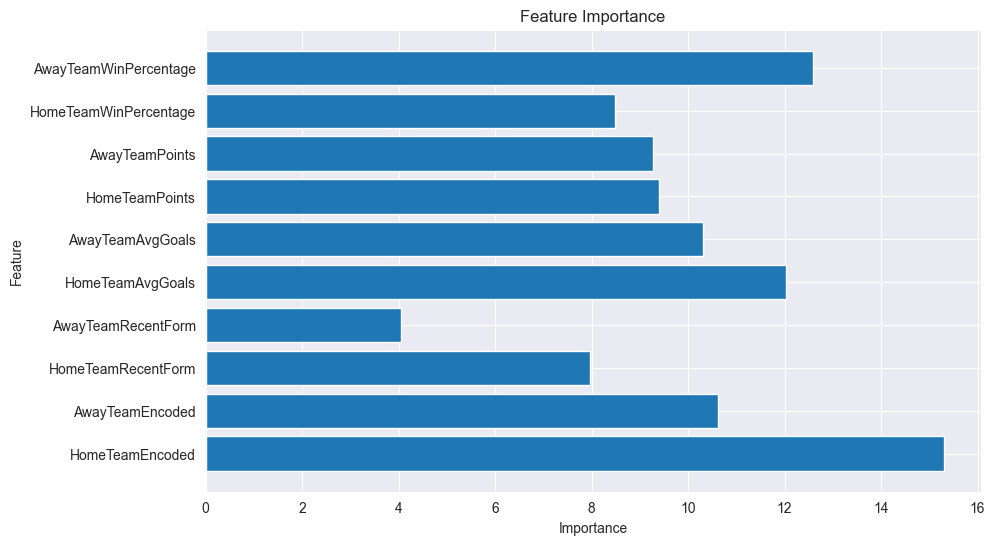

In [432]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [433]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

# newcastle vs nott'm forest
predict_match('Newcastle', "Nott'm Forest", final_model, scaler)

# bournemouth vs fulham
predict_match('Bournemouth', 'Fulham', final_model, scaler)

# sheffield vs luton
predict_match('Sheffield United', 'Luton', final_model, scaler)

# burnley vs liverpool
predict_match('Burnley', 'Liverpool', final_model, scaler)

# manchester utd vs aston villa
predict_match('Man United', 'Aston Villa', final_model, scaler)



Newcastle win probability: 0.015114808190233973
Nott'm Forest win probability: 0.9297273330265908
Draw probability: 0.0551578587831752
Bournemouth win probability: 0.6429389871792168
Fulham win probability: 0.17315927737653494
Draw probability: 0.18390173544424818
Sheffield United win probability: 0.27827706391273316
Luton win probability: 0.22596934834288016
Draw probability: 0.49575358774438655
Burnley win probability: 0.6209641619755036
Liverpool win probability: 0.03698542470786341
Draw probability: 0.342050413316633
Man United win probability: 0.6283479009544908
Aston Villa win probability: 0.26990713009956735
Draw probability: 0.10174496894594186


(0.6283479009544908, 0.26990713009956735, 0.10174496894594186)

In [434]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train_smote)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.58      0.92      0.71        12
           D       0.25      0.20      0.22         5
           H       0.92      0.63      0.75        19

    accuracy                           0.67        36
   macro avg       0.58      0.58      0.56        36
weighted avg       0.71      0.67      0.66        36


In [435]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.625


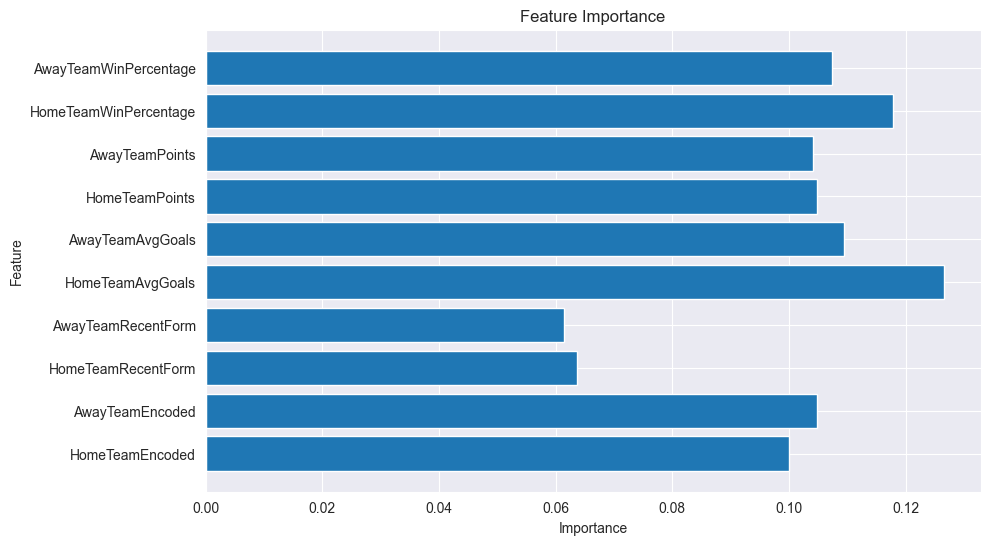

In [436]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [437]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
    draw_prob = best_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

# newcastle vs nott'm forest
predict_match('Newcastle', "Nott'm Forest", best_model, scaler)

# bournemouth vs fulham
predict_match('Bournemouth', 'Fulham', best_model, scaler)

# sheffield vs luton
predict_match('Sheffield United', 'Luton', best_model, scaler)

# burnley vs liverpool
predict_match('Burnley', 'Liverpool', best_model, scaler)

# manchester utd vs aston villa
predict_match('Man United', 'Aston Villa', best_model, scaler)


Newcastle win probability: 0.006666666666666667
Nott'm Forest win probability: 0.9333333333333333
Draw probability: 0.06
Bournemouth win probability: 0.4533333333333333
Fulham win probability: 0.16666666666666666
Draw probability: 0.38
Sheffield United win probability: 0.43
Luton win probability: 0.32
Draw probability: 0.25
Burnley win probability: 0.7633333333333333
Liverpool win probability: 0.0033333333333333335
Draw probability: 0.23333333333333334
Man United win probability: 0.5966666666666667
Aston Villa win probability: 0.20333333333333334
Draw probability: 0.2


(0.5966666666666667, 0.20333333333333334, 0.2)

In [438]:
# compare the two models
from sklearn.metrics import classification_report

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# Evaluate the model
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.62      0.83      0.71        12
           D       0.25      0.20      0.22         5
           H       0.88      0.74      0.80        19

    accuracy                           0.69        36
   macro avg       0.58      0.59      0.58        36
weighted avg       0.70      0.69      0.69        36

              precision    recall  f1-score   support

           A       0.58      0.92      0.71        12
           D       0.25      0.20      0.22         5
           H       0.92      0.63      0.75        19

    accuracy                           0.67        36
   macro avg       0.58      0.58      0.56        36
weighted avg       0.71      0.67      0.66        36


In [439]:
# save the model
import pickle

pickle.dump(best_model, open('best_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))



In [440]:
# load the model
import pickle

best_model = pickle.load(open('best_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))



In [441]:
# predict the final league table after the first 17 games
# load the fixtures which contains the first 17 games and the rest of the games
fixtures = pd.read_csv('fixturess.csv')
fixtures.tail()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
375,376,38,19/05/2024 16:00,Selhurst Park,Crystal Palace,Aston Villa,NaN
376,377,38,19/05/2024 16:00,Anfield,Liverpool,Wolves,NaN
377,378,38,19/05/2024 16:00,Kenilworth Road,Luton,Fulham,NaN
378,379,38,19/05/2024 16:00,Etihad Stadium,Man City,West Ham,NaN
379,380,38,19/05/2024 16:00,Bramall Lane,Sheffield Utd,Spurs,NaN


In [442]:
# Function to parse results and calculate points
def parse_result(row):
    if pd.isna(row['Result']) or '-' not in row['Result']:
        return [None, None, None, None]  # In case of NaN or unexpected format
    
    home_goals, away_goals = map(int, row['Result'].split(' - '))
    home_points = 3 if home_goals > away_goals else 0
    away_points = 3 if home_goals < away_goals else 0
    home_points = away_points = 1 if home_goals == away_goals else home_points
    
    return [home_goals, away_goals, home_points, away_points]

In [443]:
# Apply the function to the fixtures DataFrame
fixtures[['HomeGoals', 'AwayGoals', 'HomePoints', 'AwayPoints']] = fixtures.apply(parse_result, axis=1, result_type='expand')

In [444]:
# Create a DataFrame to hold the league standings
league_standings = pd.DataFrame({'Team': fixtures['Home Team'].unique()})
league_standings['Points'] = 0

In [445]:
# Function to update the league standings with points from a match
def update_league_standings(row, standings):
    standings.loc[standings['Team'] == row['Home Team'], 'Points'] += row['HomePoints']
    standings.loc[standings['Team'] == row['Away Team'], 'Points'] += row['AwayPoints']

# Convert points in fixtures_df to integers
fixtures['HomePoints'] = fixtures['HomePoints'].astype(float).fillna(0).astype(int)
fixtures['AwayPoints'] = fixtures['AwayPoints'].astype(float).fillna(0).astype(int)

fixtures.apply(update_league_standings, axis=1, standings=league_standings)

# Deduct 10 points from Everton for misconduct
league_standings.loc[league_standings['Team'] == 'Everton', 'Points'] -= 10


In [446]:
# map the team names to the team names in the fixtures
name_mapping = {
    'Sheffield United': 'Sheffield Utd',
    'Tottenham': 'Spurs',
    'Man United': 'Man Utd',
    'Nott\'m Forest': 'Nottingham Forest',
}

# Apply name mapping to both datasets
df_cleaned['HomeTeam'] = df_cleaned['HomeTeam'].replace(name_mapping)
df_cleaned['AwayTeam'] = df_cleaned['AwayTeam'].replace(name_mapping)
fixtures['Home Team'] = fixtures['Home Team'].replace(name_mapping)
fixtures['Away Team'] = fixtures['Away Team'].replace(name_mapping)

# Combine team names from both datasets
all_teams = pd.concat([df_cleaned['HomeTeam'], df_cleaned['AwayTeam'], fixtures['Home Team'], fixtures['Away Team']]).unique()

# Refit the label encoder

label_encoder.fit(all_teams)


LabelEncoder()

In [447]:
def preprocess_fixtures(fixtures):
    if 'Home Team' not in fixtures.columns or 'Away Team' not in fixtures.columns:
        raise ValueError("Expected columns 'Home Team' and 'Away Team' not found in the input DataFrame.")
    # Encode the team names
    fixtures['HomeTeamEncoded'] = label_encoder.transform(fixtures['Home Team'])
    fixtures['AwayTeamEncoded'] = label_encoder.transform(fixtures['Away Team'])

    # Calculate recent form
    fixtures['HomeTeamRecentForm'] = fixtures.apply(lambda x: calculate_form_points(x['Home Team'], df_cleaned), axis=1)
    fixtures['AwayTeamRecentForm'] = fixtures.apply(lambda x: calculate_form_points(x['Away Team'], df_cleaned), axis=1)

    # Calculate average goals
    fixtures['HomeTeamAvgGoals'] = fixtures.apply(
        lambda x: df_cleaned[df_cleaned['HomeTeam'] == x['Home Team']]['HomeTeamAvgGoals'].values[0] 
                  if len(df_cleaned[df_cleaned['HomeTeam'] == x['Home Team']]['HomeTeamAvgGoals']) > 0 
                  else 0, 
        axis=1
    )
    fixtures['AwayTeamAvgGoals'] = fixtures.apply(
        lambda x: df_cleaned[df_cleaned['AwayTeam'] == x['Away Team']]['AwayTeamAvgGoals'].values[0] 
                  if len(df_cleaned[df_cleaned['AwayTeam'] == x['Away Team']]['AwayTeamAvgGoals']) > 0 
                  else 0, 
        axis=1
    )

    # Calculate team points
    fixtures['HomeTeamPoints'] = fixtures.apply(lambda x: calculate_team_points(x['Home Team'], df_cleaned), axis=1)
    fixtures['AwayTeamPoints'] = fixtures.apply(lambda x: calculate_team_points(x['Away Team'], df_cleaned), axis=1)

    # Calculate win percentage
    fixtures['HomeTeamWinPercentage'] = fixtures['Home Team'].map(home_team_win_percentage_map).fillna(0)
    fixtures['AwayTeamWinPercentage'] = fixtures['Away Team'].map(away_team_win_percentage_map).fillna(0)

    # Select only the columns that are used as features in the model
    model_features = [
        'HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm',
        'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints',
        'HomeTeamWinPercentage', 'AwayTeamWinPercentage'
    ]
    
    # Return a DataFrame with only the model features
    return fixtures[model_features]


In [448]:
print(fixtures.columns)

Index(['Match Number', 'Round Number', 'Date', 'Location', 'Home Team',
       'Away Team', 'Result', 'HomeGoals', 'AwayGoals', 'HomePoints',
       'AwayPoints'],
      dtype='object')


In [449]:
# preprocess the fixtures
fixtures = preprocess_fixtures(fixtures)
fixtures.head()

,HomeTeamEncoded,AwayTeamEncoded,HomeTeamRecentForm,AwayTeamRecentForm,HomeTeamAvgGoals,AwayTeamAvgGoals,HomeTeamPoints,AwayTeamPoints,HomeTeamWinPercentage,AwayTeamWinPercentage
0,5,12,7,6,1.111111,2.000000,11,34,0.111111,0.555556
1,0,15,10,1,2.444444,0.777778,40,14,0.777778,0.000000
2,2,18,13,10,1.000000,1.555556,22,30,0.250000,0.444444
3,4,11,5,6,2.000000,0.875000,27,12,0.444444,0.125000
4,8,9,12,6,1.111111,1.000000,26,21,0.333333,0.111111


In [450]:
# Define the function to update points for each match
def update_points(row, standings):
    if row['Result'] == 'H':
        standings.loc[standings['Team'] == row['Home Team'], 'Points'] += 3
    elif row['Result'] == 'A':
        standings.loc[standings['Team'] == row['Away Team'], 'Points'] += 3
    elif row['Result'] == 'D':  # It's a draw
        standings.loc[standings['Team'] == row['Home Team'], 'Points'] += 1
        standings.loc[standings['Team'] == row['Away Team'], 'Points'] += 1

# Loop over the fixtures to predict outcomes for the unplayed games and update the league table
# Loop over the fixtures to predict outcomes for unplayed games and update the league table
for index, row in fixtures.iterrows():
    if pd.isna(row['Result']):
        match_to_predict = pd.DataFrame([row.drop(labels=['Result'])])
        processed_fixture = preprocess_fixtures(match_to_predict)
        prediction = final_model.predict(processed_fixture)
        fixtures.at[index, 'Result'] = prediction[0]
        update_points(fixtures.iloc[index], league_standings)

# Sort the league table and display the final league standings
final_league_table = league_standings.sort_values(by='Points', ascending=False).reset_index(drop=True)
print(final_league_table.head(20))


KeyError: 'Result'